# PROGRAMMING EXERCISES
## 1. Digit Recognizer
### 1(a) Load data


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt

train=pd.read_csv("digit-recognizer/train.csv")
test=pd.read_csv("digit-recognizer/test.csv")

In [2]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1) 
print(X_train.shape)

(42000, 28, 28, 1)


### 1(b) Display digit images

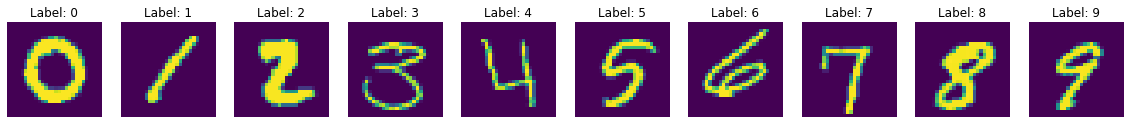

In [3]:
plt.rcParams['figure.figsize'] = [20, 10]
_, axes = plt.subplots(1, 10)

one2ten_index = [[] for i in range(10)] 


for index, digit in enumerate(Y_train):
    one2ten_index[digit].append(index)

for dig, ax in enumerate(axes):
    ax.set_axis_off()
    ax.imshow(X_train[one2ten_index[dig][0]][:,:,0])
    ax.set_title('Label: %d' % dig)


### 1(c) Examine the prior probability of the classes in the training data. Is it uniform across the digits? Display a normalized histogram of digit counts. Is it even?

1. It is not uniform across the digits because the number of each digit is different;
2. Even the number of each digit is different, they are roughly same size.

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

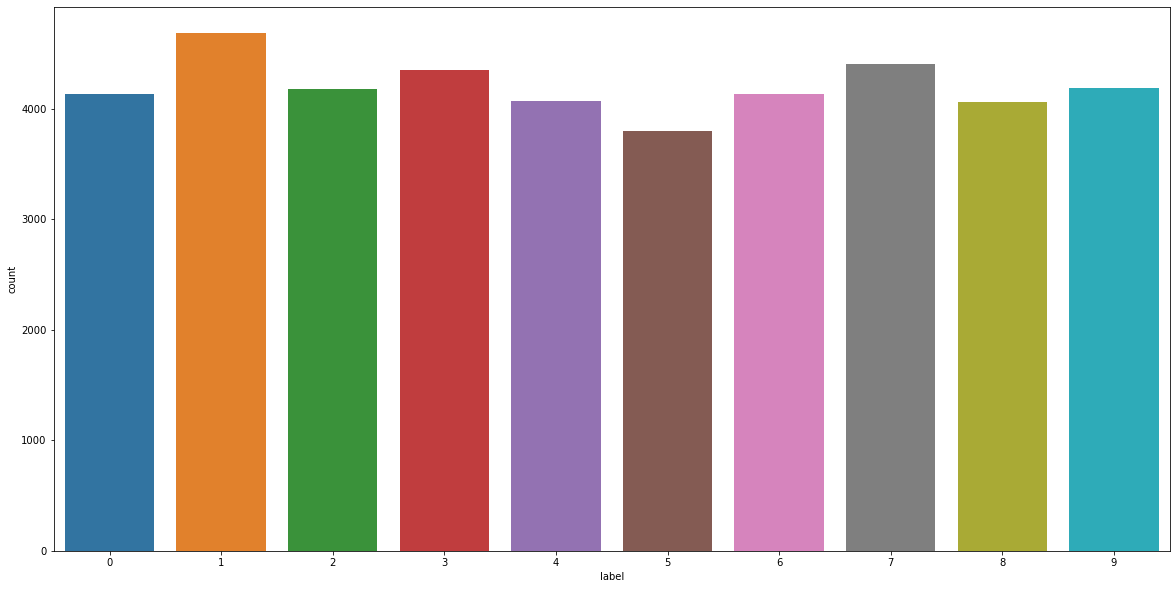

In [4]:
g = sns.countplot(Y_train)

Y_train.value_counts()

### 1(d) Pick one example of each digit from your training data. Then, for each sample digit, compute and show the best match (nearest neighbor) between your chosen sample and the rest of the training data. Use L2 distance between the two images’ pixel values as the metric. This probably won’t be perfect, so add an asterisk next to the erroneous examples (if any).

In [5]:
minpos_list = []
for digit in range(0,10):
    dist, sample = [], one2ten_index[digit][0]
    for index in one2ten_index[digit]:
        L2_dist = np.linalg.norm(X_train[sample]-X_train[index])
        dist.append(L2_dist)
        
    dist[0] = sys.maxsize # so it won't pick itself as min
    minidx = dist.index(min(dist)) # this position is position in one2ten_index[digit], which is a list of index to X_train
    minpos = one2ten_index[digit][minidx] # this is the index in X_train
    minpos_list.append(minpos)

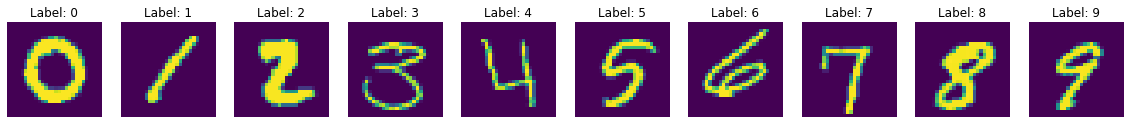

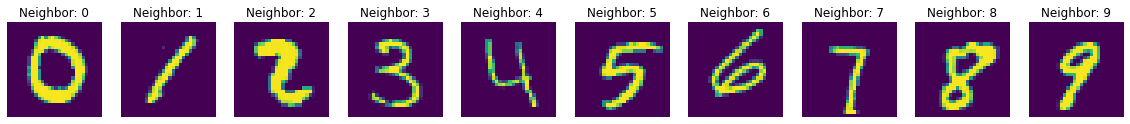

In [6]:
plt.rcParams['figure.figsize'] = [20, 10]
_, axes_sample = plt.subplots(1, 10)
_, axes_neighbor = plt.subplots(1, 10)

for dig, ax in enumerate(axes_sample):
    ax.set_axis_off()
    ax.imshow(X_train[one2ten_index[dig][0]][:,:,0])
    ax.set_title('Label: %d' % dig)

for dig, ax in enumerate(axes_neighbor):
    ax.set_axis_off()
    ax.imshow(X_train[minpos_list[dig]][:,:,0])
    ax.set_title('Neighbor: %d' % dig)

### 1(e) Consider the case of binary comparison between the digits 0 and 1. Ignoring all the other digits, compute the pairwise distances for all genuine matches and all impostor matches, again using the L2 norm. Plot histograms of the genuine and impostor distances on the same set of axes.

In [7]:
%%capture
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm as tqdm
tqdm().pandas()

In [8]:
dist_gen = [] 
dist_imp = []
all_zero_digit = X_train[one2ten_index[0]] # all zero digit images
all_one_digit = X_train[one2ten_index[1]] # all one digit images

oneNzero = np.append(all_zero_digit, all_one_digit, axis = 0)

bond = len(one2ten_index[0]) # the index of first one = 4132. total 8816, 4684 1s

for sample in tqdm(range(len(oneNzero))):
    for j in range(len(oneNzero)):
        # sample_j
        zero_zero = (sample < bond) and (j < bond)
        one_one = (sample >= bond) and (j >= bond)
        one_zero = (sample >= bond and j < bond)
        L2_dist = np.linalg.norm(oneNzero[sample]-oneNzero[j])
        if zero_zero or one_one:
            dist_gen.append(L2_dist)
        else:
            dist_imp.append(L2_dist)

100%|██████████| 8816/8816 [09:46<00:00, 15.02it/s]


In [9]:
print(len(dist_gen))
print(len(dist_imp))

39013280
38708576


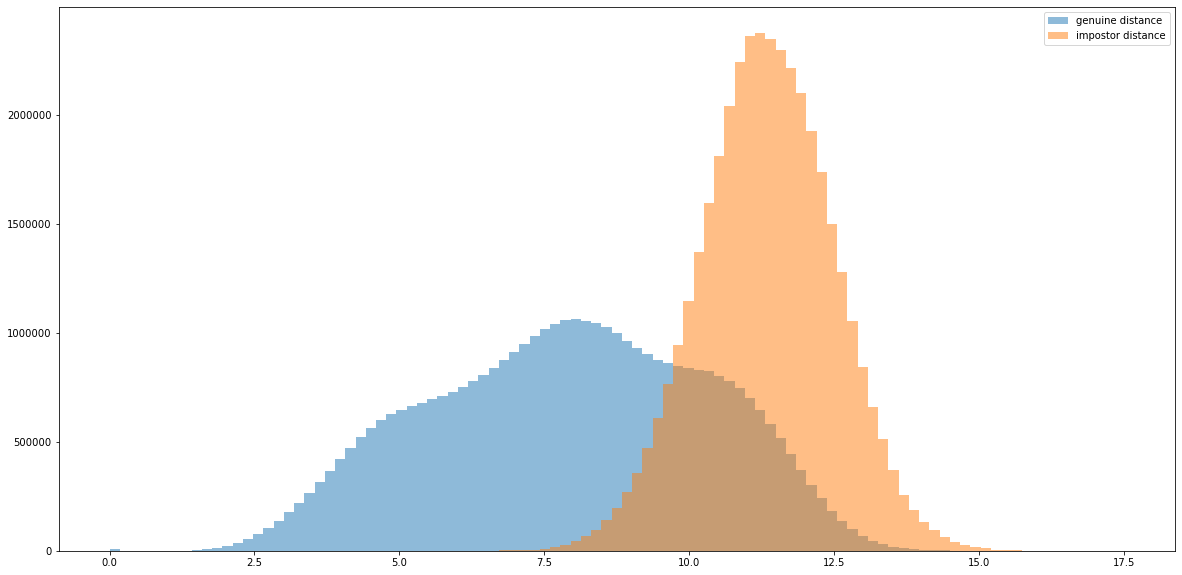

In [10]:
bins = np.linspace(0, 17.5, 100)
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.hist(dist_gen, bins, alpha=0.5, label='genuine distance')
plt.hist(dist_imp, bins, alpha=0.5, label='impostor distance')
plt.legend(loc='upper right')
plt.show()

### 1(f) Generate an ROC curve from the above sets of distances. What is the equal error rate? What is the error rate of a classifier that simply guesses randomly?

(4000,)
(4000,)


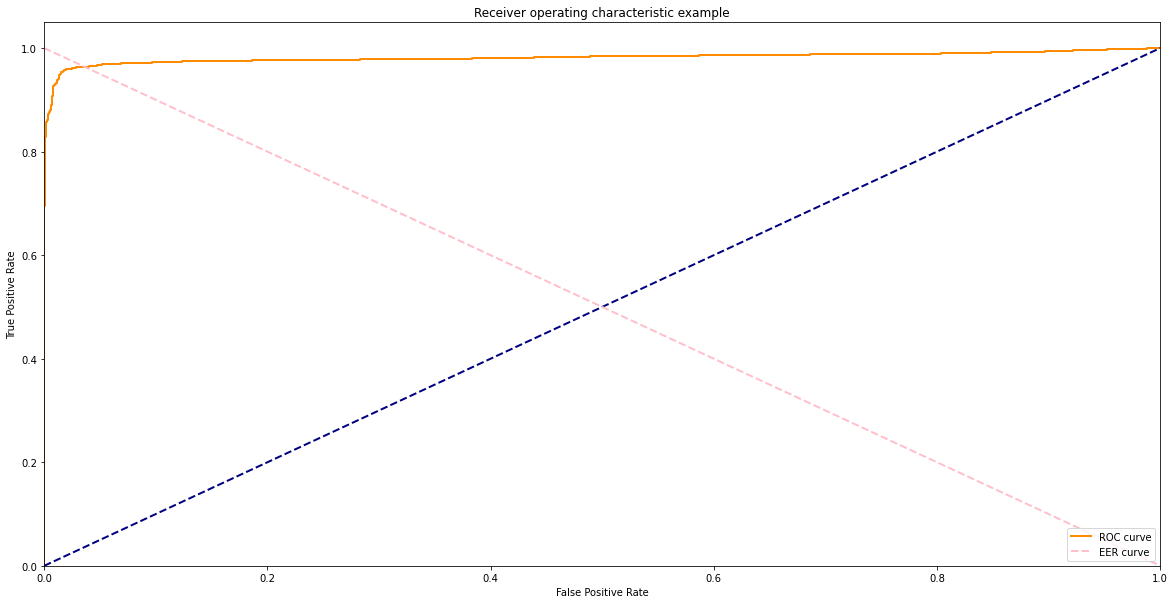

In [43]:
from sklearn import metrics
size = 2000
dist_gen_sliced = dist_gen[:size]
dist_imp_sliced = dist_imp[:size]

y_true = np.full((len(dist_gen_sliced),), 1)  # the index of last zero
y_true = np.append(y_true, np.full((len(dist_gen_sliced),), 0))  # the index of last zero

print(y_true.shape)

scores = -np.append(dist_gen_sliced, dist_imp_sliced)


print(scores.shape)

fpr, tpr, thresholds = metrics.roc_curve(y_true, scores)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot([0, 1], [1, 0], color='pink', lw=lw, linestyle='--', label='EER curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


### (g) Implement a K-NN classifier. (You cannot use external libraries for this question; it should be your own implementation.)

In [12]:
# Make a prediction with K nearest neighbors
def KNN_classifier(X_train, Y_train, X_test, k):
    X_pred = []
    distances = [] # a list of tuples, [0] is X_Y, [1] is L2_distance
    X_train = X_train.values.tolist()
    Y_train = Y_train.values.tolist()
    X_test = X_test.values.tolist()    
    Y_X_set = tuple(zip(Y_train, X_train))  
    
    for sample in X_test: # for every sample in test set
        for Y_X in Y_X_set: # for every sample in train set, find all the distances
            L2_dist = 0;
            L2_dist = np.linalg.norm(np.subtract(sample, Y_X[1])) # Y_X[1] index is 1 because it is X_train
            distance_tup = (Y_X[0], L2_dist)
            distances.append(distance_tup)
        sorted(distances, key=lambda tup: tup[1]) # sort based on L2_dist
        neighbors = []
        for i in range(k): # find the most common label in K (neighbors)
            neighbors.append(distances[i][0])
#             print(distances[i][0])
        pred_label = max(set(neighbors), key=neighbors.count)
        print(neighbors)
        X_pred.append(pred_label)
    return X_pred

### (h) Take 15% of your dataset and make it your holdout set. Train the classifier on the remaining data, using different values of K and use the holdout set to determine the best value of K . Print a table showing the values of K you tried as well as their training and holdout accuracy. Report the best value of K that you found.

100%|██████████| 6/6 [30:57<00:00, 309.56s/it]


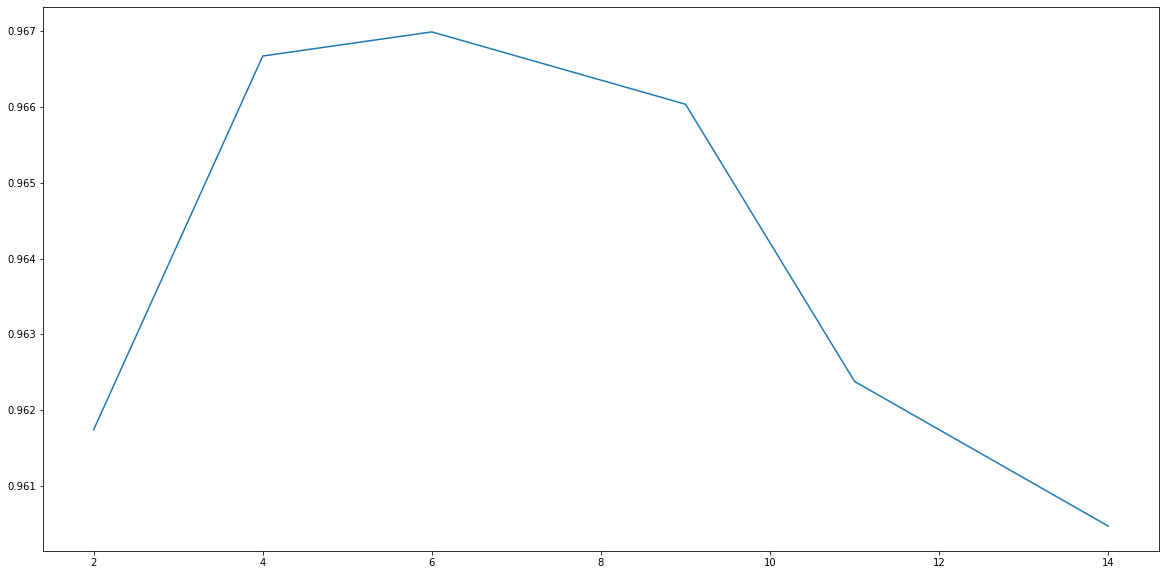

In [13]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score
train=pd.read_csv("digit-recognizer/train.csv")
# data_size = 4000
# train = train[:data_size] # make the data set smaller
hold_idx = int((1-0.15) * train.shape[0])

Y_train = train["label"]
Y_true = Y_train[hold_idx:]
Y_train = Y_train[:hold_idx]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 
X_test = X_train[hold_idx:]
X_train = X_train[:hold_idx]
# free some space
del train 

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

Y_true = Y_true.to_numpy() # convert from pandas series to ndarray

def k_accuracy(k_set):
    accuracy = []
    for k in tqdm(k_set):
        clf = neighbors.KNeighborsClassifier(n_neighbors = int(k), metric='minkowski', p=2)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        accuracy.append(accuracy_score(Y_true, Y_pred))
    return accuracy


k_set = np.linspace(2, 14, 6, dtype = np.int16)
k_accuracy_set = k_accuracy(k_set)
plt.plot(k_set, k_accuracy_set, label="accuracy function")

In [14]:
pd.concat([pd.Series(k_set), pd.Series(k_accuracy_set)], axis=1)

,0,1
0,2,0.961746
1,4,0.966667
2,6,0.966984
3,9,0.966032
4,11,0.962381
5,14,0.960476


In [15]:
# the best k is k=6
clf = neighbors.KNeighborsClassifier(n_neighbors = int(6), metric='minkowski', p=2)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

### (i) Generate a confusion matrix (of size 10×10) from your results. Which digits are particularly tricky to classify?

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_true, Y_pred)

array([[643,   0,   0,   0,   0,   1,   1,   0,   0,   0],
       [  0, 713,   0,   0,   0,   0,   0,   0,   0,   0],
       [  5,   6, 570,   2,   0,   1,   0,  11,   1,   1],
       [  2,   2,   6, 629,   0,   5,   0,   1,   1,   2],
       [  0,   8,   0,   0, 616,   0,   1,   2,   0,  12],
       [  2,   2,   0,  10,   0, 522,   7,   0,   1,   3],
       [  3,   2,   0,   0,   2,   1, 627,   0,   0,   0],
       [  0,   8,   3,   0,   1,   0,   0, 617,   0,   2],
       [  2,  19,   1,   8,   4,   8,   3,   1, 574,   4],
       [  5,   1,   2,   6,   9,   1,   0,  16,   0, 581]])

In [ ]:
print(Y_true)

### (j) Train your classifier with all of the training data, and test your classifier with the test data. Submit your results to Kaggle.

In [5]:
train=pd.read_csv("digit-recognizer/train.csv")
test=pd.read_csv("digit-recognizer/test.csv")

# handle train set
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 
# free some space
del train 

X_test = test

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
# the best k is k=6
clf = neighbors.KNeighborsClassifier(n_neighbors = int(6), metric='minkowski', p=2)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

In [21]:
output = []
for i in range(1, len(Y_pred)+1):
    output.append(i)
print(Y_pred.shape, len(output))


(28000,) 28000


In [22]:
id_col = ["ImageId"]
Label_col = ["Label"]
new_df = pd.DataFrame({"Label":Y_pred})

submission = pd.DataFrame({
        "ImageId": output,
        "Label":Y_pred
    })
submission.to_csv('SubmissionHW1.1.1.csv',index=False)

## 2. Predicting House Prices

In [23]:
#HW1.2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()
train.describe()


#Take out useful values I want
new_columns = ["PoolArea","MiscVal","MoSold","YrSold"]
x_train = train[new_columns]
y_train = train["SalePrice"]
x_test = test[new_columns]

#train on PoolArea and make prediction
x_train_pool = x_train.loc[:,['PoolArea']]
x_test_pool = x_test.loc[:,['PoolArea']]

regr = linear_model.LinearRegression()
#fit on the train data
regr.fit(x_train_pool, y_train)

#predict on test data
y_test_pred = regr.predict(x_test_pool)

# print('Slope (theta1) for accuracy: \t', regr.coef_[0])  182.70934030078107
# print('Slope (theta0) for accuract : \t', regr.intercept_)  180417.1183405948

print ('Slope (theta1) on poolArea of test dataset: \t', regr.coef_[0]) # 182.70934030078107
print('Slope(theta0) on test dataset: \t', regr.intercept_ )  #  180417.1183405948
print("\n")
#Based on value of theta1 and theta0, we can know that the higher the saleprice is

# train on Misc value and the make prediction
x_train_Misc = x_train.loc[:,['MiscVal']]
x_test_Misc = x_test.loc[:,['MiscVal']]

regr2 = linear_model.LinearRegression()
regr2.fit(x_train_Misc, y_train)
y_test_pred2 = regr2.predict(x_test_Misc)

print ('Slope (theta1) on miscvlaue of test dataset: \t', regr2.coef_[0]) # -3.3930157615667067
print('Slope (theta0) on test dataset : \t', regr2.intercept_) #181068.7548923047
print("\n")
#Thus, the bigger the miscvalue is, the lower the saleprice is


#train on Mosold and make prediction
x_train_mo = x_train.loc[:,['MoSold']]
x_test_mo = x_test.loc[:,['MoSold']]

regr3 = linear_model.LinearRegression()
regr3.fit(x_train_mo, y_train)
y_test_pred3 = regr3.predict(x_test_mo)

print ('Slope (theta1) on MoSold of test dataset: \t', regr3.coef_[0]) # 1364.3505021688502
print('Slope (theta0) on test dataset : \t', regr3.intercept_) #172295.88415409692
print("\n")

#train on  Yrsold and make prediction
x_train_yr = x_train.loc[:,['YrSold']]
x_test_yr = x_test.loc[:,['YrSold']]

regr4 = linear_model.LinearRegression()
regr4.fit(x_train_yr, y_train)
y_test_pred4 = regr4.predict(x_test_yr)

print ('Slope (theta1) on YrSold of test dataset: \t', regr4.coef_[0]) #  -1730.0587285436372
print('Slope (theta0) on test dataset : \t', regr4.intercept_)
print("\n")



Slope (theta1) on poolArea of test dataset: 	 182.7093403007808
Slope(theta0) on test dataset: 	 180417.1183405948


Slope (theta1) on miscvlaue of test dataset: 	 -3.393015761566699
Slope (theta0) on test dataset : 	 181068.7548923047


Slope (theta1) on MoSold of test dataset: 	 1364.3505021688507
Slope (theta0) on test dataset : 	 172295.88415409692


Slope (theta1) on YrSold of test dataset: 	 -1730.058728543637
Slope (theta0) on test dataset : 	 3654560.3654101584




In [24]:
# Part C for L1 regularization AKA Lasso Regression

model_lasso = LassoCV(alphas = [1,0.1,0.001,0.0005])
lasso1 = model_lasso.fit(x_train_pool, y_train)
y_pred_lasso1 = lasso1.predict(x_test_pool)#182.70933999
score1 = lasso1.score(x_train_pool, y_train)

print('lasso coefficient for the 1st prediction is: ',lasso1.coef_)
print('score is: ', score1) #0.008538415958697199
print('\n')

lasso2 = model_lasso.fit(x_train_Misc, y_train)
y_pred_lasso2 = lasso2.predict(x_test_Misc)#-3.3930117
score2 = lasso2.score(x_train_Misc, y_train)
print('lasso coefficient for the 2nd prediction is: ', lasso2.coef_)
print('score is: ', score2) #0.00044899828533218056
print('\n')

lasso3 = model_lasso.fit(x_train_mo, y_train)
y_pred_lasso3 = lasso3.predict(x_test_mo) #1364.33681214
score3 = lasso3.score(x_train_mo, y_train)
print('lasso coefficient for the 3rd prediction is: ', lasso3.coef_)
print('score is: ', score3) #0.0021559533965250788
print('\n')

lasso4 = model_lasso.fit(x_train_yr, y_train)
y_pred_lasso4 = lasso4.predict(x_test_yr) #-1730.00199509
score4 = lasso4.score(x_train_yr, y_train)
print('lasso coefficient for the 4th prediction is: ',lasso4.coef_)
print('score is: ', score4) #0.000836515842886465
print("\n")

#Part C for L2 regularization AKA Ridge regression
alpha = 10
ridge = Ridge(max_iter = 100, alpha = alpha)
ridge1 = ridge.fit(x_train_pool, y_train)
y_pred_ridge1 = ridge1.predict(x_test_pool)
r_score1 = ridge1.score(x_train_pool, y_train)
print('Ridge coefficient for the 1st prediction is: ',ridge1.coef_) #182.70856451
print ('score is: ', r_score1) #0.00853841595854321
print('\n')

ridge2 = ridge.fit(x_train_Misc, y_train)
y_pred_ridge2 = ridge2.predict(x_test_Misc)
r_score2 = ridge2.score(x_train_Misc, y_train)
print('Ridge coefficient for the 2nd prediction is: ',ridge2.coef_) # -3.39301567
print('score is: ', r_score2) #0.00044899828533262465
print('\n')

ridge3 = ridge.fit(x_train_mo, y_train)
y_pred_ridge3 = ridge3.predict(x_test_mo)
r_score3 = ridge3.score(x_train_mo, y_train)
print('Ridge coefficient for the 3rd prediction is: ',ridge3.coef_) #1363.07238599]
print('score is: ', r_score3) #0.0021559515044946576
print('\n')

ridge4 = ridge.fit(x_train_yr, y_train)
y_pred_ridge4 = ridge4.predict(x_test_yr)
r_score4 = ridge4.score(x_train_yr, y_train)
print('Ridge coefficient for the 4th prediction is: ',ridge4.coef_)  #-1723.36199749
print('score is: ', r_score4) #0.0008365033991728499


final_list = y_test_pred + y_test_pred2 + y_test_pred3 + y_test_pred4
#In Summary, from the output data, we can tell that training regularized and unregularized
# models can produce simialr results with tiny differences. In essence, Lasso regression is 
#a type of regression applying coordinate descent. Ridge regression works when the number of 
#predictor variables exceeds the amount of observations. Overall, the regularized models can refine
#the results produced according to linear regression. To compare L1 and L2 regularization, we can compare
#the scores produced by L1 and L2 regularizations under specific situation. From the data,


lasso coefficient for the 1st prediction is:  [182.70933999]
score is:  0.008538415958697199


lasso coefficient for the 2nd prediction is:  [-3.3930117]
score is:  0.00044899828533218056


lasso coefficient for the 3rd prediction is:  [1364.35043372]
score is:  0.0021559533965250788


lasso coefficient for the 4th prediction is:  [-1729.49139403]
score is:  0.000836515842886465


Ridge coefficient for the 1st prediction is:  [182.70856451]
score is:  0.00853841595854321


Ridge coefficient for the 2nd prediction is:  [-3.39301567]
score is:  0.00044899828533262465


Ridge coefficient for the 3rd prediction is:  [1363.07238599]
score is:  0.0021559515044946576


Ridge coefficient for the 4th prediction is:  [-1723.36199749]
score is:  0.0008365033991730719


In [25]:
id_col = test["Id"]
sale = ["SalePrice"]
new_df = pd.DataFrame({"SalePrice":sale})

submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice":y_test_pred3
    })
submission.to_csv('Submission1.1.2.csv',index=False)